In [1]:
from datasets import load_dataset
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from itertools import islice
from collections import defaultdict
import re
from tqdm import tqdm
import torch
from torch import nn
import numpy as np
import gc
from matplotlib import pyplot as plt
import datasets
from torch.utils.data import DataLoader

%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/workspace/FutureGPT2/src/')
from models.myopic_model import *

In [3]:
#model_name = 'stanford-crfm/alias-gpt2-small-x21'
#model_name = 'EleutherAI/pythia-160m-deduped'
model_name = 'EleutherAI/pythia-2.8b'
tokenizer = AutoTokenizer.from_pretrained(model_name)
Token = {v: k for k, v in tokenizer.get_vocab().items()}

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
vanilla_state = torch.load(
    '/workspace/checkpoints/checkpoints_PYTHIA_UNSHARD/PYTHIA-PILE10M64-VANILLA-fp16_model_name_pythia-2.8b_lr_6.40e-05_warmup_5.00e-02_global_step=1627.0_train_loss=2.44.ckpt'
)['state_dict']
myopic_state = torch.load(
    '/workspace/checkpoints/checkpoints_PYTHIA_UNSHARD/PYTHIA-PILE10M64-MYOPIC-fp16_model_name_pythia-2.8b_lr_6.40e-05_warmup_5.00e-02_global_step=1627.0_train_loss=2.67.ckpt'
)['state_dict']

In [13]:
orig = AutoModelForCausalLM.from_pretrained(model_name).to('cuda')
vanilla = AutoModelForCausalLM.from_pretrained(model_name).to('cuda')
myopic = AutoModelForCausalLM.from_pretrained(model_name).to('cuda')
vanilla.load_state_dict({'.'.join(k.split('.')[1:]): v for k, v in vanilla_state.items()})
myopic.load_state_dict({'.'.join(k.split('.')[1:]): v for k, v in myopic_state.items()})

<All keys matched successfully>

In [14]:
models = {
    'orig': orig,
    'vanilla': vanilla,
    'myopic': myopic,
}

In [4]:
ds = load_dataset('pg19', split='validation', streaming=True)

/home/wwu/.local/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for pg19 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/pg19
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [21]:
msmarco = datasets.load_from_disk('/workspace/corpus/msmarco/msmarco_GPT2_64tokens_full/val').with_format('torch', device='cuda')
msmarco_l = DataLoader(msmarco, batch_size=512)

In [33]:
orig_loss = 0
myopic_loss = 0
for batch in tqdm(iter(msmarco_l)):
    del batch['text']
    del batch['id']
    batch['labels'] = batch['input_ids']
    orig_out = orig(**batch)
    orig_loss += orig_out.loss
    myopic = to_myopic_gpt2(
        myopic, 
        past_key_values=orig_out.past_key_values
    )
    myopic_out = myopic(**batch)
    myopic_loss += myopic_out.loss

100%|██████████| 102/102 [01:55<00:00,  1.13s/it]


In [36]:
myopic_loss / 102

tensor(3.1952, device='cuda:0')

In [8]:
def batched(iterable, n):
    "Batch data into lists of length n. The last batch may be shorter."
    # batched('ABCDEFG', 3) --> ABC DEF G
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            return
        yield batch

In [9]:
torch.set_grad_enabled(False)
gc.collect()
torch.cuda.empty_cache()

In [21]:
ds_iter = iter(ds)
batch_size = 8
ce = nn.CrossEntropyLoss(reduction='none')
loss = {k: 0. for k in models}
total = 0
seq_len = 256
for x in ds_iter:
    print(x['short_book_title'], x['publication_date'])
    if x['publication_date'] < 1900:
        print('SKIPPING')
        continue
    text = re.sub('[\\r\\n]+', ' ', x['text'])
    tokens = tokenizer(text, return_tensors='pt').to('cuda')
    ntok = tokens['input_ids'].shape[-1]
    print('TOKENS', ntok)
    for idxs in tqdm(
        batched(list(range(ntok))[1000:-2000], batch_size), 
        #total=5000,
        total=(ntok-3000)//batch_size+1
    ):
        gc.collect()
        torch.cuda.empty_cache()
        batch = defaultdict(lambda: [])
        for idx in idxs:
            for k in tokens.keys():
                # one extra so that we have loss for last
                batch[k].append(torch.take(tokens[k], torch.arange(idx, idx + seq_len + 1, device='cuda')))
    
        for k in tokens.keys():
            batch[k] = torch.stack(batch[k])

        # batch['input_ids'][:,9] = 21219 # POTATO
        for key, model in models.items():
            out = model(**{k: batch[k][:,:-1] for k in batch})
            loss[key] +=  ce(
                out.logits.transpose(1, 2),
                batch['input_ids'][:,1:]
            ).mean(dim=0).cpu().numpy()
        total += 1
    break

Walking by Henry David Thoreau 1862
SKIPPING
The Atlantic Monthly Vol. 7 No. 42 April 1861 by Various 1861
SKIPPING
The Making of Arguments by J. H. Gardiner 1912
TOKENS 116492


 12%|█▏        | 1681/14187 [1:07:47<8:24:20,  2.42s/it]


KeyboardInterrupt: 

In [22]:
for k in loss:
    loss[k] /= total

In [25]:
for k in loss:
    np.save(f'/workspace/data/pos_v_loss_pythia_2.8b_{k}', loss[k])

In [19]:
#np.save('/workspace/data/pos_v_loss_myopic_fixed', myopic_loss)

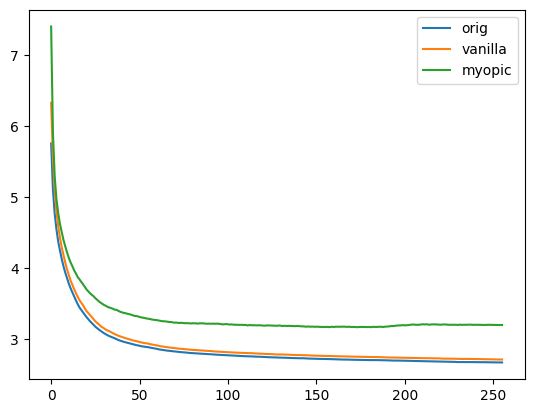

In [23]:
for k in loss:
    plt.plot(loss[k], label=k)
plt.legend()
plt.show()

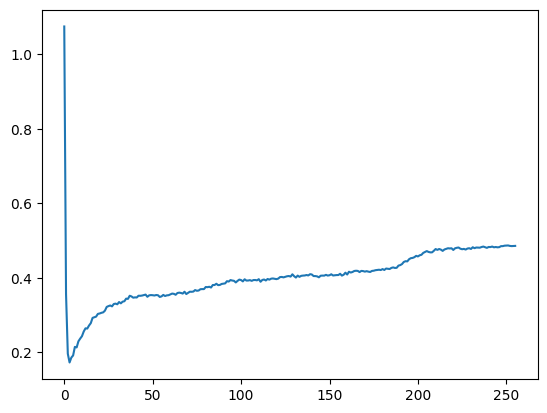

In [24]:
plt.plot(loss['myopic'] - loss['vanilla'])

In [20]:
myopic_loss.mean()

4.765144

In [21]:
orig_loss.mean()

4.669932

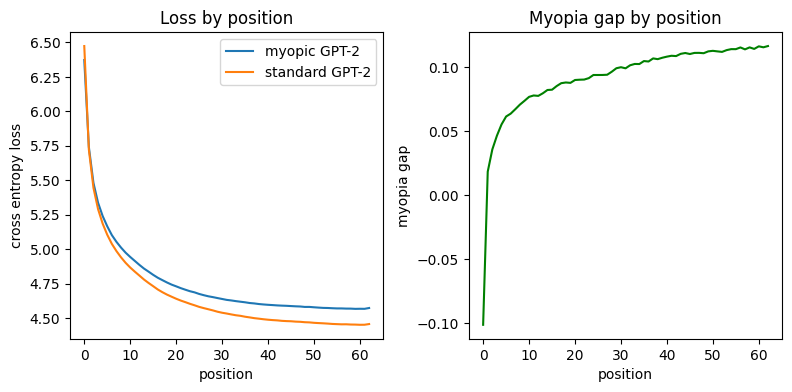

In [18]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1, aspect='auto')
plt.plot(myopic_loss[:-1], label='myopic GPT-2')
plt.plot(orig_loss[:-1], label='standard GPT-2')
plt.xlabel('position')
plt.ylabel('cross entropy loss')
plt.title('Loss by position')
plt.legend()
plt.subplot(1, 2, 2, aspect='auto')
plt.plot(myopic_loss[:-1] - orig_loss[:-1], 'g')
plt.xlabel('position')
plt.ylabel('myopia gap')
plt.title('Myopia gap by position')
plt.tight_layout(pad=1.0)
plt.show()

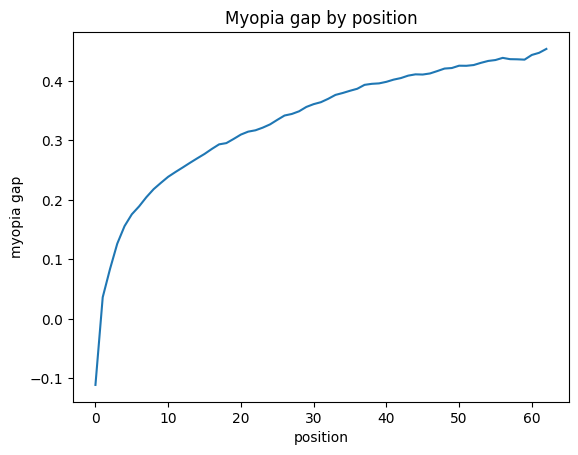

In [28]:

plt.show()

In [50]:
loss_d

{'A': array([6.367593 , 5.60604  , 5.343363 , 5.194177 , 5.096787 , 5.0210705,
        4.95562  , 4.906314 , 4.864349 , 4.824686 , 4.7913103, 4.760518 ,
        4.7334056, 4.7047834, 4.680171 , 4.6567593, 4.634316 , 4.614789 ,
        4.596826 , 4.5809255, 4.5651984, 4.5517554, 4.5388207, 4.525949 ,
        4.514195 , 4.499752 , 4.4909277, 4.481451 , 4.470225 , 4.460719 ,
        4.4526253, 4.445723 , 4.4396367, 4.435053 , 4.4311986, 4.4238157,
        4.416647 , 4.4110746, 4.406531 , 4.4027777, 4.399292 , 4.395485 ,
        4.3940463, 4.390957 , 4.3892465, 4.388928 , 4.387489 , 4.3869753,
        4.383172 , 4.382287 , 4.3777328, 4.37557  , 4.3741455, 4.372342 ,
        4.3705754, 4.368885 , 4.365784 , 4.366625 , 4.36473  , 4.363691 ,
        4.361747 , 4.3612213, 4.3656588, 4.4629025, 4.5301805, 4.5763764,
        4.6157365, 4.640425 , 4.6654077, 4.735154 ], dtype=float32),
 'D': array([6.3707514, 6.0929646, 6.0134535, 6.0189943, 6.020053 , 5.9852962,
        5.961923 , 5.9415455, 5.9

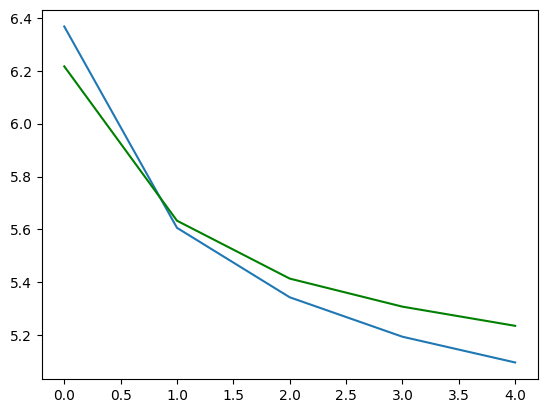

In [67]:
plt.plot(loss_d['A'][:5])
#plt.plot(loss_d['D'][:10], c='r')
plt.plot(loss_d['F'][:5], c='g')
plt.show()

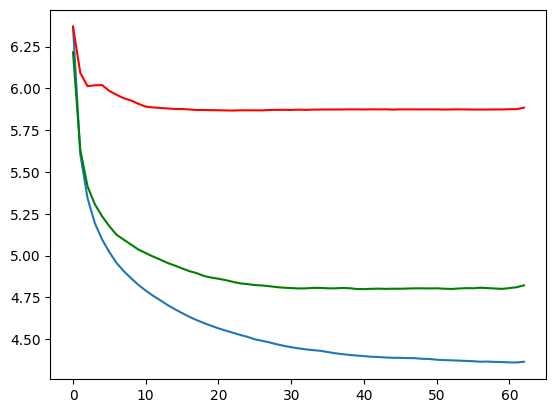

In [54]:
plt.plot(loss_d['A'][:63])
plt.plot(loss_d['D'][:63], c='r')
plt.plot(loss_d['F'][:63], c='g')
plt.show()

In [ ]:
loss[:10]

In [ ]:
loss.shape

In [ ]:
plt.plot(list(range(1024))[-200:], loss[-200:])

In [ ]:
loss[1022]

In [ ]:
wpe = model.transformer.wpe.weight.cpu().numpy()

In [ ]:
plt.plot(np.linalg.norm(wpe, axis=1))

In [ ]:
np.linalg.norm(wpe, axis=1)

In [ ]:
U, S, V = np.linalg.svd(wpe)

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
plot = ax.scatter(U[:,0], U[:,1], U[:,2], cmap='jet', c=range(1024))
fig.colorbar(plot)
plt.show()

In [ ]:
model = AutoModelForCausalLM.from_pretrained(model_name, checkpoint='checkpoint- ')

In [68]:
del model

In [69]:
del batch